In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import illustris_python as il

#constants
h_tng = 0.678 #Planck 2015
h_sami = 0.7
h_b = 0.7 #behroozi
h_z = 0.7 #Zanisi
G = 4.3*10**(-6) #  kpc/M_o*(km/s)**2

In [2]:
def masses(df):
    keys = df.keys()
    for key in keys:
        if "Mass" in key:
            df[key] = df[key]*10**10/h_tng
    return df

def color(df):
    bands = ["g", "r", "i"]
    for i in range(3):
        for j in range(i+1, 3):
            key1 = "SubhaloStellarPhotometrics_" + bands[i]
            key2 = "SubhaloStellarPhotometrics_" + bands[j]
            for key in df.keys():
                if (key1 in key):
                    radkey = key.replace(key1, "")
                    if (key2 + radkey) in df.keys():
                        df["SubhaloColor_" + bands[i] + "-" + bands[j] + radkey] = df[key1 + radkey] - df[key2 + radkey]
    return df

def double_power_law(b, c, M1, N):
    xmin, xmax = 9, 14
    x=np.logspace(xmin,xmax,200)
    y = 2*N*x*((x/M1)**(-b)+(x/M1)**(c))**(-1)
    return x,y

def power_law_log (C, a, xmin, xmax):
    x = np.linspace(xmin, xmax)
    y = a*x + C
    return x, y

def behroozi(a, M1, c, d, e):
    def f(x):
        f = -np.log10(10**(a*x)+1)+d*((np.log10(1+np.exp(x)))**c)/(1+np.exp(10**(-x)))
        return f
    xmin, xmax = 9, 14
    X=np.logspace(xmin,xmax,200)
    Y_log = np.log10(e*M1)+f(np.log10(X/M1)) - f(0) #gives log(y)
    return X, 10**(Y_log)

In [3]:
def late_type_SFR(df, rad_key):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR" + rad_key] < 0.036].index
    df_copy = df_copy.drop(index_names)
    
    return df_copy

def early_type_SFR(df, rad_key):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhalosSFR" + rad_key] > 0.01148].index
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_gas(df, rad_key):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhaloGasFraction" + rad_key] < 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_gas(df, rad_key):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["SubhaloGasFraction" + rad_key] > 0.1].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def late_type_kappa(df, rad_key):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["Kappa_rot" + rad_key] < 0.6].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def early_type_kappa(df, rad_key):
    df_copy = df.copy(deep=True)
    index_names = df_copy[df_copy["Kappa_rot" + rad_key] > 0.6].index #Ferrero2020
    df_copy = df_copy.drop(index_names)
    return df_copy

def clean_subhalos(df, idlist):
    df_copy = df.copy(deep=True)
    index_names = np.array([])
    df_id = np.array(df_copy["id"])
    for item in df_id:
        if item not in idlist:
            index_names = np.append(index_names, df_copy[df_copy["id"]==item].index)
    df_copy = df_copy.drop(index_names)
    #df_copy = df_copy.drop_duplicates(subset='id', keep="first")
    return df_copy

In [4]:
old = pd.read_pickle("../data/tng-100-1/cutdata/Subhalo_Centrals_minE9_5_SM.pkl")
#general = pd.read_pickle("../data/tng-100-1/catalogues/mass_vel_photo_2303.pkl")
vel1 = pd.read_pickle("../data/tng-100-1/catalogues/velocities_0505.pkl")
vel2 = pd.read_csv("../data/tng-100-1/catalogues/veldisp_proj_Total_0405.csv")
aper1 = pd.read_pickle("../data/tng-100-1/catalogues/30_kpc_0105.pkl")
aper2 = pd.read_pickle("../data/tng-100-1/catalogues/15Rvir_0305.pkl") 
vel1.sort_values(by="id", inplace = True)
vel2.sort_values(by="id", inplace = True)
aper1.sort_values(by="id", inplace = True)
aper2.sort_values(by="id", inplace = True)
aper = aper1.join(aper2, lsuffix="DROP").filter(regex="^(?!.*DROP)")
vel = vel1.join(vel2, rsuffix="DROP").filter(regex="^(?!.*DROP)")

#new1 = general.join(vel, lsuffix="DROP").filter(regex="^(?!.*DROP)")
new = aper.join(vel, lsuffix="DROP").filter(regex="^(?!.*DROP)")
sami = pd.read_csv("../data/SAMI/dr3.csv")
sami = sami[sami["mstar_log"]>9.5]
sami_dr2 = pd.read_csv("../data/SAMI/all_data_vrot_dr2.csv")
old.sort_values(by="id", inplace = True)
new.sort_values(by="id", inplace = True)
new = clean_subhalos(new, list(old["id"]))

print(len(old), len(new), len(vel))
print(new.keys())
#Masses
old = masses(old)
new = masses(new)

#sSFR and gas fraction
new["SubhalosSFR30kpc"] = 10**(9)*new["SubhaloSFR30kpc"]/new["SubhaloMassStellar30kpc"]
new["SubhalosSFR15Rvir"] = 10**(9)*new["SubhaloSFR15Rvir"]/new["SubhaloMassStellar15Rvir"]
new["SubhaloGasFractionTotal"] = new["SubhaloMassGasTotal"]/new["SubhaloMassStellarTotal"]
new["SubhaloGasFraction30kpc"] = new["SubhaloMassGas30kpc"]/new["SubhaloMassStellar30kpc"]
new["SubhaloGasFraction15Rvir"] = new["SubhaloMassGas15Rvir"]/new["SubhaloMassStellar15Rvir"]

old["SubhalosSFR"] = 10**(9)*old["SubhaloSFR"]/old["SubhaloMassStellar"]
old["SubhaloGasFraction"] = old["SubhaloMassGas"]/old["SubhaloMassStellar"]
old["SubhaloGasFraction2Re"] = old["SubhaloMassInRadGas"]/old["SubhaloMassInRadStellar"]
old["SubhaloGasFractionRe"] = old["SubhaloMassInHalfRadGas"]/old["SubhaloMassInHalfRadStellar"]

#Half mass rad

new["SubhaloHalfmassRadProjTotal"] = ((new["SubhaloHalfmassRad_xyTotal"]**2 + new["SubhaloHalfmassRad_xzTotal"]**2 + new["SubhaloHalfmassRad_yzTotal"]**2)*(1/3))**(1/2)
new["SubhaloHalfmassRadProj30kpc"] = ((new["SubhaloHalfmassRad_xy30kpc"]**2 + new["SubhaloHalfmassRad_xz30kpc"]**2 + new["SubhaloHalfmassRad_yz30kpc"]**2)*(1/3))**(1/2)
new["SubhaloHalfmassRadProj15Rvir"] = ((new["SubhaloHalfmassRad_xy15Rvir"]**2 + new["SubhaloHalfmassRad_xz15Rvir"]**2 + new["SubhaloHalfmassRad_yz15Rvir"]**2)*(1/3))**(1/2)

for key in new.keys():
    if "SubhaloHalfmassRad" in key:
        new[key] = new[key]/h_tng
for key in old.keys():
    if "SubhaloHalfmassRad" in key:
        old[key] = old[key]/h_tng

#Adding color
new = color(new)
old = color(old)


7304 7303 7304
Index(['SubhaloSFR30kpc', 'SubhaloMassGas30kpc', 'SubhaloMassDM30kpc',
       'SubhaloMass30kpc', 'SubhaloMassInHalfRadGas30kpc',
       'SubhaloMassInHalfRadDM30kpc', 'SubhaloMassInHalfRadStellar30kpc',
       'SubhaloMassInHalfRad30kpc', 'AngularMomentumX30kpc',
       'AngularMomentumY30kpc',
       ...
       'SubhaloMassStellar10kpc', 'SubhaloHalfmassRadStellar10kpc',
       'SubhaloVelDisp3D_Gas_10kpc', 'SubhaloVelDisp3D_DM_10kpc', 'Unnamed: 0',
       'SubhaloHalfmassRad_xyTotal', 'SubhaloHalfmassRad_xzTotal',
       'SubhaloHalfmassRad_yzTotal', 'SubhaloVelDispReProjectedStellarTotal',
       'SubhaloVelDisp3D_Stellar_Re_Total'],
      dtype='object', length=101)


In [5]:
ids = new["id"]
for key in ids:
    if len(new[new["id"]==key])>1:
        print(key)

In [6]:
sami["mstar"] = sami["mstar"]*h_sami**2/(h_tng**2)
sami["r_e_circ"] = sami["r_e_circ"]*h_sami/h_tng
sami["r_e"] = sami["r_e"]*h_sami/h_tng
sami["r_mge"] = sami["r_mge"]*h_sami/h_tng
sami["g_i"] = sami["g_i"] #+ 5*np.log(h_tng) - 5*np.log(h_sami)

In [7]:
for key in new.keys():
    if "3D" in key:
        new_key = key.replace("3D", "1D")
        new[new_key] = new[key]*(1/3)**(1/2)

In [8]:
new_earlies = early_type_kappa(early_type_SFR(new, "30kpc"), "30kpc")
new_lates = late_type_kappa(late_type_SFR(new, "30kpc"), "30kpc")
new_earlies_SFR = early_type_SFR(new, "30kpc")
new_lates_SFR = late_type_SFR(new, "30kpc")


new_earlies_id = new_earlies["id"].values
new_lates_id = new_lates["id"].values
new_id = new["id"].values

old_earlies = old[old["id"].isin(new_earlies_id)]
old_lates = old[old["id"].isin(new_lates_id)]
old = old[old["id"].isin(new_id)]

#SFR
new_earlies_SFR_id = new_earlies_SFR["id"].values
new_lates_SFR_id = new_lates_SFR["id"].values
old_earlies_SFR = old[old["id"].isin(new_earlies_SFR_id)]
old_lates_SFR = old[old["id"].isin(new_lates_SFR_id)]

sami_earlies = sami[sami["type"] <= 1]
sami_earlies = sami_earlies[sami_earlies["type"] > -1]
sami_earlies_2 = sami[sami["type"] <= 0]
sami_earlies_2 = sami_earlies_2[sami_earlies_2["type"] > -1]
sami_lates = sami[sami["type"] >= 3]
sami_lates = sami_lates[sami_lates["type"] <= 3]
sami_lates_2 = sami[sami["type"] >= 2]
sami_lates_2 = sami_lates_2[sami_lates_2["type"] <= 3]

#Log format
new_log = il.formatplot.log_formater(new)
old_log = il.formatplot.log_formater(old)
new_earlies_log = il.formatplot.log_formater(new_earlies)
new_earlies_SFR_log = il.formatplot.log_formater(new_earlies_SFR)
old_earlies_log = il.formatplot.log_formater(old_earlies)
old_earlies_SFR_log = il.formatplot.log_formater(old_earlies_SFR)
new_lates_log = il.formatplot.log_formater(new_lates)
new_lates_SFR_log = il.formatplot.log_formater(new_lates_SFR)
old_lates_log = il.formatplot.log_formater(old_lates)
old_lates_SFR_log = il.formatplot.log_formater(old_lates_SFR)

sami_log = il.formatplot.log_formater_sami(sami)
sami_earlies_log = il.formatplot.log_formater_sami(sami_earlies)
sami_earlies_2_log = il.formatplot.log_formater_sami(sami_earlies_2)
sami_lates_log = il.formatplot.log_formater_sami(sami_lates)
sami_lates_2_log = il.formatplot.log_formater_sami(sami_lates_2)


print(len(new_earlies), len(new_lates), len(new)-len(new_earlies)-len(new_lates))
print(len(old_earlies), len(old_lates), len(old)-len(old_earlies)-len(old_lates))
print(len(sami_earlies), len(sami_lates), len(sami)-len(sami_earlies)-len(sami_lates))


1335 1453 4515
1335 1453 4515
1216 425 1415


In [9]:
for key in new.keys():
    print(key)

SubhaloSFR30kpc
SubhaloMassGas30kpc
SubhaloMassDM30kpc
SubhaloMass30kpc
SubhaloMassInHalfRadGas30kpc
SubhaloMassInHalfRadDM30kpc
SubhaloMassInHalfRadStellar30kpc
SubhaloMassInHalfRad30kpc
AngularMomentumX30kpc
AngularMomentumY30kpc
AngularMomentumZ30kpc
SpecificAngularMomentumX30kpc
SpecificAngularMomentumY30kpc
SpecificAngularMomentumZ30kpc
RotationalEnergy30kpc
KineticEnergy30kpc
Kappa_rot30kpc
SubhaloRotVelRe30kpc
SubhaloRotVelRe2230kpc
SubhaloVelDisp3D_Stellar_30kpc
SubhaloVelDisp3D_Gas_30kpc
SubhaloVelDisp3D_DM_30kpc
SubhaloStellarPhotometrics_g30kpc
SubhaloStellarPhotometrics_r30kpc
SubhaloStellarPhotometrics_i30kpc
SubhaloStellarPhotometrics_z30kpc
SubhaloSFR15Rvir
SubhaloMassGas15Rvir
SubhaloMassDM15Rvir
SubhaloMassStellar
SubhaloMass15Rvir
SubhaloHalfmassRadStellar
SubhaloMassInHalfRadGas15Rvir
SubhaloMassInHalfRadDM15Rvir
SubhaloMassInHalfRadStellar15Rvir
SubhaloMassInHalfRad15Rvir
AngularMomentumX15Rvir
AngularMomentumY15Rvir
AngularMomentumZ15Rvir
SpecificAngularMomentumX15

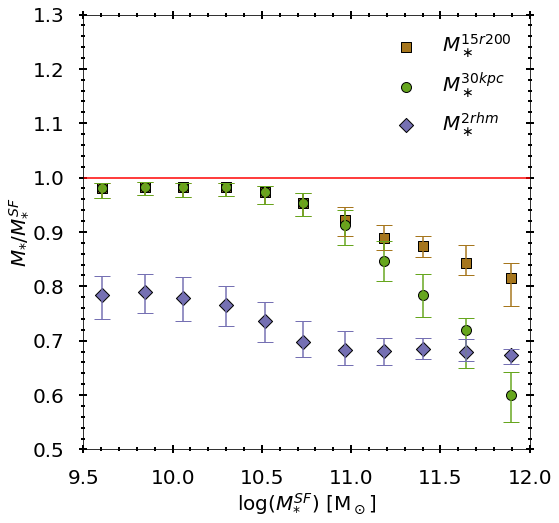

In [31]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
mass_total_log = old_log["SubhaloMassStellar"].values
mass_total = old["SubhaloMassStellar"].values
mass_15 = new["SubhaloMassStellar15Rvir"].values
mass_30 = new["SubhaloMassStellar30kpc"].values
mass_2r = old["SubhaloMassInRadStellar"].values

frac_15 = mass_15/mass_total
frac_30 = mass_30/mass_total
frac_2r = mass_2r/mass_total

x_med15, y_med15, x_err15, y_err15 = il.stats.median_errors(mass_total_log, frac_15, 9.5, 12)
x_med30, y_med30, x_err30, y_err30 = il.stats.median_errors(mass_total_log, frac_30, 9.5, 12)
x_med2r, y_med2r, x_err2r, y_err2r = il.stats.median_errors(mass_total_log, frac_2r, 9.5, 12)

#axs.scatter(mass_total_log, frac_30, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values
axs.errorbar(x_med15, y_med15, yerr=y_err15, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med15, y_med15, marker='s', s=100, color="#a6761d", edgecolors = "black", label = r"$M_\ast^{15r200}$")
axs.errorbar(x_med30, y_med30, yerr=y_err30, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med30, y_med30, marker='o', s=100, color="#66a61e", edgecolors = "black", label = r"$M_\ast^{30kpc}$")
axs.errorbar(x_med2r, y_med2r, yerr=y_err2r, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med2r, y_med2r, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"$M_\ast^{2rhm}$")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fSM(ax=axs, y0 = 0.5, y1 = 1.3)
plt.savefig("../fig/SM_fSM.png", dpi=300, bbox_inches='tight')

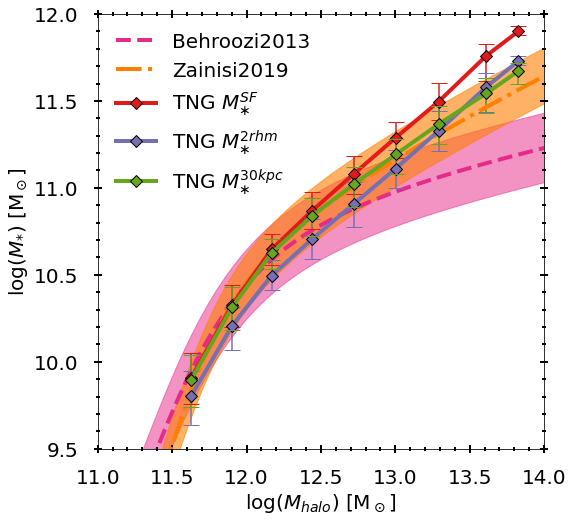

In [33]:
#Create the plot
fig, ax = plt.subplots(figsize = (8,8))

#Behroozi 2013
B2013x, B2013y = behroozi(a=-1.412, M1=10**(11.514), c=0.316, d=3.508, e=10**(-1.777))
#converting to same cosmology
B2013x = B2013x*h_b/h_tng
B2013y = B2013y*h_b**2/h_tng**2
#Adding maximum error in log format
B_err_lower = np.log10(B2013y) - 0.2
B_err_upper = np.log10(B2013y) + 0.2
ax.plot(np.log10(B2013x), np.log10(B2013y), "--", c="#e7298a", linewidth=4, label= "Behroozi2013")
ax.fill_between(np.log10(B2013x), B_err_lower, B_err_upper, alpha=0.5, color="#e7298a")

#Zainisi 2019
Z2019x, Z2019y = behroozi(a=-2.352, M1=10**(11.632), c = 0.600, d=3.797, e=10**(-1.785))
#converting to same cosmology
Z2019x = Z2019x*h_z/h_tng
Z2019y = Z2019y*h_z**2/h_tng**2
#Adding maximum error in log format
#Z_errors = il.stats.error_estimate_behroozi(a=-2.352, M1=10**(11.632), c = 0.600, d=3.797, e=10**(-1.785), delta_a=0.026, delta_M1=0.008, delta_c=0.1, delta_d=0.052, delta_e=0.01, x=Z2019x)
Z_err_lower = np.log10(Z2019y) - 0.16 #Z_errors
Z_err_upper = np.log10(Z2019y) + 0.16 #Z_errors
ax.plot(np.log10(Z2019x), np.log10(Z2019y), "-.", c="#ff7f00", linewidth=4, label= "Zainisi2019")
ax.fill_between(np.log10(Z2019x), Z_err_lower, Z_err_upper, alpha=0.6, color="#ff7f00")

#Calculate mean values TNG
SF_x = old_log["SubhaloMass"].values
SF_y = old_log["SubhaloMassStellar"].values
mSF_x, mSF_y, eSF_x, eSF_y = il.stats.median_errors(SF_x, SF_y, 11.5, 14, 10)
#eSF_x, eSF_y = il.stats.log_errors(eSF_x, eSF_y, mSF_x, mSF_y)
ax.errorbar(mSF_x, mSF_y, yerr=eSF_y, capsize = 8, color="#e31a1c", marker='^', fmt = 'none')
ax.plot(mSF_x, mSF_y, marker='D', linewidth=4, markersize=8, c="#e31a1c", markeredgecolor = "black", label = r"TNG $M_{\ast}^{SF}$")

#Calculate mean values TNG
SF2_x = old_log["SubhaloMass"].values
SF2_y = old_log["SubhaloMassInRadStellar"].values
mSF2_x, mSF2_y, eSF2_x, eSF2_y = il.stats.median_errors(SF2_x, SF2_y, 11.5, 14, 10)
#eSF_x, eSF_y = il.stats.log_errors(eSF_x, eSF_y, mSF_x, mSF_y)
ax.errorbar(mSF2_x, mSF2_y, yerr=eSF2_y, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
ax.plot(mSF2_x, mSF2_y, marker='D', linewidth=4, markersize=8, c="#7570b3", markeredgecolor = "black", label = r"TNG $M_{\ast}^{2rhm}$")

#Calculate mean values TNG
TNG_x = old_log["SubhaloMass"].values
TNG_y = new_log["SubhaloMassStellar30kpc"].values
mTNG_x, mTNG_y, eTNG_x, eTNG_y = il.stats.median_errors(TNG_x, TNG_y, 11.5, 14, 10)
#eTNG_x, eTNG_y = il.stats.log_errors(eTNG_x, eTNG_y, mTNG_x, mTNG_y)
ax.errorbar(mTNG_x, mTNG_y, yerr=eTNG_y, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
ax.plot(mTNG_x, mTNG_y, marker='D', linewidth=4, markersize=8, c="#66a61e", markeredgecolor = "black", label = r"TNG $M_{\ast}^{30kpc}$")


il.formatplot.HM_SM(ax=ax, y0=9.5, y1=12, x0=11, x1=14)
plt.savefig("../fig/shmr.png", dpi=300, bbox_inches='tight')

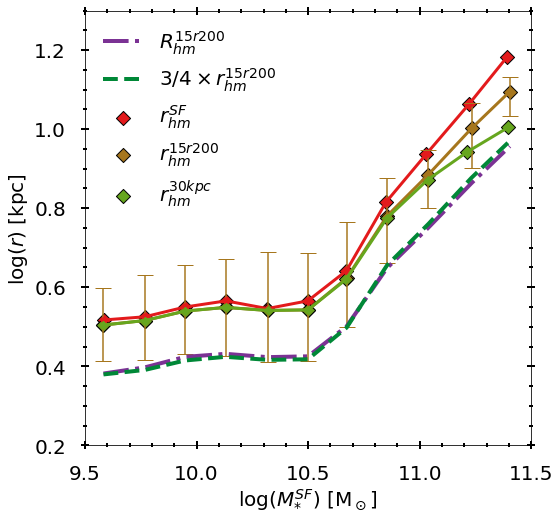

In [54]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
mass_total = old_log["SubhaloMassStellar"].values
mass_30 = new_log["SubhaloMassStellar30kpc"].values
mass_15 = new_log["SubhaloMassStellar15Rvir"].values
r_total = old_log["SubhaloHalfmassRadStellar"].values
r_15 = new_log["SubhaloHalfmassRadStellar15Rvir"].values
r_30 = new_log["SubhaloHalfmassRadStellar30kpc"].values
r_15_proj = new_log["SubhaloHalfmassRadProj15Rvir"].values
r_15_proj_simple = (np.log10(3/4)+new_log["SubhaloHalfmassRadStellar15Rvir"]).values


x_med_total, y_med_total, x_err_total, y_err_total = il.stats.median_errors(mass_total, r_total, 9.5, 11.5)
x_med_15, y_med_15, x_err_15, y_err_15 = il.stats.median_errors(mass_15, r_15, 9.5, 11.5)
x_med_30, y_med_30, x_err_30, y_err_30 = il.stats.median_errors(mass_30, r_30, 9.5, 11.5)
x_med_15_proj, y_med_15_proj, x_err_15_pro, y_err_15_pro = il.stats.median_errors(mass_15, r_15_proj, 9.5, 11.5)
x_med_15_proj_simple, y_med_15_proj_simple, x_err_15_proj_simple, y_err_15_proj_simple = il.stats.median_errors(mass_15, r_15_proj_simple, 9.5, 11.5)

#axs.scatter(mass_total_log_log, r_15, s=5, alpha=0.8, color="#a6cee3",)
#Plot median values

#axs.errorbar(x_med_total, y_med_total, yerr=y_err_total, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med_total, y_med_total, marker='D', s=100, color="#e31a1c", edgecolors = "black", label = r"$r^{SF}_{hm}$")
axs.plot(x_med_total, y_med_total, marker='D', linewidth=3, color="#e31a1c")

axs.errorbar(x_med_15, y_med_15, yerr=y_err_15, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med_15, y_med_15, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"$r^{15r200}_{hm}$")
axs.plot(x_med_15, y_med_15, marker='D', linewidth=3, color="#a6761d")

#axs.errorbar(x_med_30, y_med_30, yerr=y_err_30, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med_30, y_med_30, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"$r^{30kpc}_{hm}$")
axs.plot(x_med_30, y_med_30, marker='D', linewidth=3, color="#66a61e")


axs.plot(x_med_15_proj, y_med_15_proj, "-.", linewidth=4, color="#7b3294", label = r"$R^{15r200}_{hm}$")

axs.plot(x_med_15_proj_simple, y_med_15_proj_simple, "--", linewidth=4, color="#008837", label = r"$3/4 \times r^{15r200}_{hm}$")

il.formatplot.SM_R(ax=axs, x0= 9.5, x1= 11.5, y0=0.2, y1=1.3)
axs.set_xlabel(r"$\log(M_{*}^{SF})$ [$ \mathrm{M}_\odot $]", fontsize=20)
plt.savefig("../fig/SM_R_tng.png", dpi=300, bbox_inches='tight')

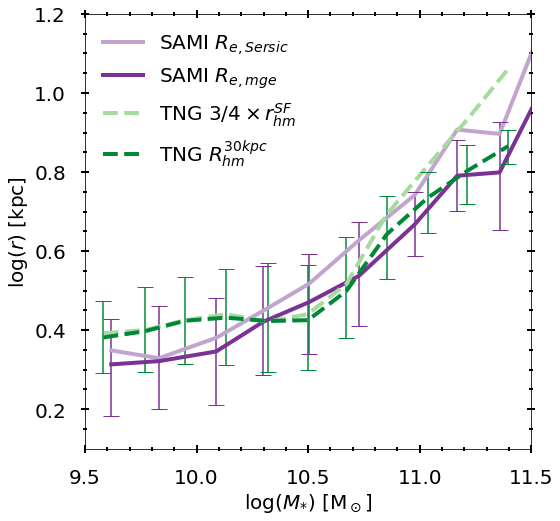

In [51]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points

x_med_s_re, y_med_s_re, x_err_s_re, y_err_s_re = il.stats.median_values_df(sami_log, "sami", "mstar", "r_e_circ", xmin=9.5, xmax=12, n=12, error_out=True)
x_med_s_rmge, y_med_s_rmge, x_err_s_rmge, y_err_s_rmge = il.stats.median_values_df(sami_log, "sami", "mstar", "r_mge", xmin=9.5, xmax=12, n=12, error_out=True)

mass_total = old_log["SubhaloMassStellar"].values
mass_30 = new_log["SubhaloMassStellar30kpc"].values
r_30 = new_log["SubhaloHalfmassRadProj30kpc"].values
r_SF_proj = (old_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values

x_med_30, y_med_30, x_err_30, y_err_30 = il.stats.median_errors(mass_30, r_30, 9.5, 11.5)
x_med_SF_proj, y_med_SF_proj, x_err_SF_proj, y_err_SF_proj = il.stats.median_errors(mass_total, r_SF_proj, 9.5, 11.5)

#plot
axs.plot(x_med_s_re, y_med_s_re, linewidth=4, color="#c2a5cf", label = r"SAMI $R_{e, Sersic}$")
axs.errorbar(x_med_s_rmge, y_med_s_rmge, yerr=y_err_s_rmge, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs.plot(x_med_s_rmge, y_med_s_rmge, linewidth=4, color="#7b3294", label = r"SAMI $R_{e, mge}$")
axs.plot(x_med_SF_proj, y_med_SF_proj, "--", linewidth=4, color="#a6dba0", label = r"TNG $3/4 \times r^{SF}_{hm}$")
axs.errorbar(x_med_30, y_med_30, yerr=y_err_30, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs.plot(x_med_30, y_med_30, "--", linewidth=4, color="#008837", label = r"TNG $R^{30kpc}_{hm}$")


il.formatplot.SM_R(ax=axs, x0= 9.5, x1= 11.5, y0=0.1, y1=1.2)
plt.savefig("../fig/SM_R.png", dpi=300, bbox_inches='tight')

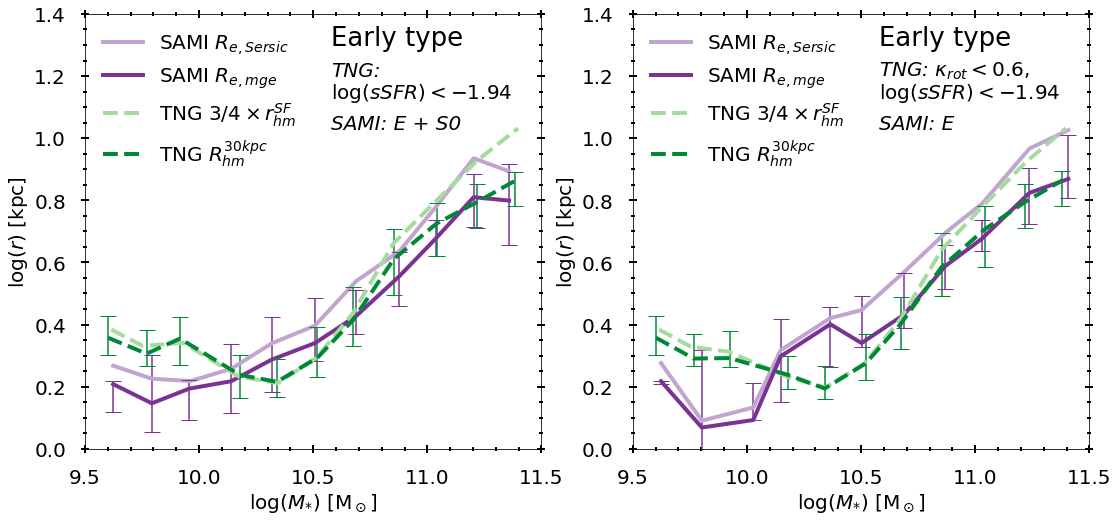

In [52]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8))

#Early type
x_med_s_re_E, y_med_s_re_E, x_err_s_re_E, y_err_s_re_E = il.stats.median_values_df(sami_earlies_log, "sami", "mstar", "r_e_circ", xmin=9.5, xmax=11.5, error_out=True)
x_med_s_rmge_E, y_med_s_rmge_E, x_err_s_rmge_E, y_err_s_rmge_E = il.stats.median_values_df(sami_earlies_log, "sami", "mstar", "r_mge", xmin=9.5, xmax=11.5, error_out=True)

mass_total_E = old_earlies_SFR_log["SubhaloMassStellar"].values
mass_30_E = new_earlies_SFR_log["SubhaloMassStellar30kpc"].values
r_30_E = new_earlies_SFR_log["SubhaloHalfmassRadProj30kpc"].values
r_SF_proj_E = (old_earlies_SFR_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values

x_med_30_E, y_med_30_E, x_err_30_E, y_err_30_E = il.stats.median_errors(mass_30_E, r_30_E, 9.5, 11.5)
x_med_SF_proj_E, y_med_SF_proj_E, x_err_SF_proj_E, y_err_SF_proj_E = il.stats.median_errors(mass_total_E, r_SF_proj_E, 9.5, 11.5)

#plot

axs[0].plot(x_med_s_re_E, y_med_s_re_E, linewidth=4, color="#c2a5cf", label = r"SAMI $R_{e, Sersic}$")
axs[0].errorbar(x_med_s_rmge_E, y_med_s_rmge_E, yerr=y_err_s_rmge_E, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs[0].plot(x_med_s_rmge_E, y_med_s_rmge_E, linewidth=4, color="#7b3294", label = r"SAMI $R_{e, mge}$")
axs[0].plot(x_med_SF_proj_E, y_med_SF_proj_E, "--", linewidth=4, color="#a6dba0", label = r"TNG $3/4 \times r^{SF}_{hm}$")
axs[0].errorbar(x_med_30_E, y_med_30_E, yerr=y_err_30_E, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs[0].plot(x_med_30_E, y_med_30_E, "--", linewidth=4, color="#008837", label = r"TNG $R^{30kpc}_{hm}$")
#Format
il.formatplot.SM_R(axs[0], x0= 9.5, x1= 11.5, y0=0.0, y1=1.4)
axs[0].text(10.58, 1.3, "Early type", fontsize=26)
axs[0].text(10.58, 1.2, r'TNG:', fontsize=20, fontstyle="italic")
axs[0].text(10.58, 1.13, r'$\log(sSFR) < -1.94$', fontsize=20, fontstyle="italic") 
axs[0].text(10.58, 1.03, r'SAMI: E + S0', fontsize=20, fontstyle="italic") 

#Early type
x_med_s_re_E, y_med_s_re_E, x_err_s_re_E, y_err_s_re_E = il.stats.median_values_df(sami_earlies_2_log, "sami", "mstar", "r_e_circ", xmin=9.5, xmax=11.5, error_out=True)
x_med_s_rmge_E, y_med_s_rmge_E, x_err_s_rmge_E, y_err_s_rmge_E = il.stats.median_values_df(sami_earlies_2_log, "sami", "mstar", "r_mge", xmin=9.5, xmax=11.5, error_out=True)
#sami_earlies_2_log.plot.scatter("mstar", "r_mge", ax=axs[1])

mass_total_E = old_earlies_log["SubhaloMassStellar"].values
mass_30_E = new_earlies_log["SubhaloMassStellar30kpc"].values
r_30_E = new_earlies_log["SubhaloHalfmassRadProj30kpc"].values
r_SF_proj_E = (old_earlies_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values

x_med_30_E, y_med_30_E, x_err_30_E, y_err_30_E = il.stats.median_errors(mass_30_E, r_30_E, 9.5, 11.5)
x_med_SF_proj_E, y_med_SF_proj_E, x_err_SF_proj_E, y_err_SF_proj_E = il.stats.median_errors(mass_total_E, r_SF_proj_E, 9.5, 11.5)

#plot

axs[1].plot(x_med_s_re_E, y_med_s_re_E, linewidth=4, color="#c2a5cf", label = r"SAMI $R_{e, Sersic}$")
axs[1].errorbar(x_med_s_rmge_E, y_med_s_rmge_E, yerr=y_err_s_rmge_E, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs[1].plot(x_med_s_rmge_E, y_med_s_rmge_E, linewidth=4, color="#7b3294", label = r"SAMI $R_{e, mge}$")
axs[1].plot(x_med_SF_proj_E, y_med_SF_proj_E, "--", linewidth=4, color="#a6dba0", label = r"TNG $3/4 \times r^{SF}_{hm}$")
axs[1].errorbar(x_med_30_E, y_med_30_E, yerr=y_err_30_E, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs[1].plot(x_med_30_E, y_med_30_E, "--", linewidth=4, color="#008837", label = r"TNG $R^{30kpc}_{hm}$")
#Format
il.formatplot.SM_R(axs[1], x0= 9.5, x1= 11.5, y0=0.0, y1=1.4)
axs[1].text(10.58, 1.3, "Early type", fontsize=26)
axs[1].text(10.58, 1.2, r'TNG: $\kappa_{rot} < 0.6,$', fontsize=20, fontstyle="italic")
axs[1].text(10.58, 1.13, r'$\log(sSFR) < -1.94$', fontsize=20, fontstyle="italic") 
axs[1].text(10.58, 1.03, r'SAMI: E', fontsize=20, fontstyle="italic") 

plt.savefig("../fig/SM_R_earlies.png", dpi=300, bbox_inches='tight')


C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


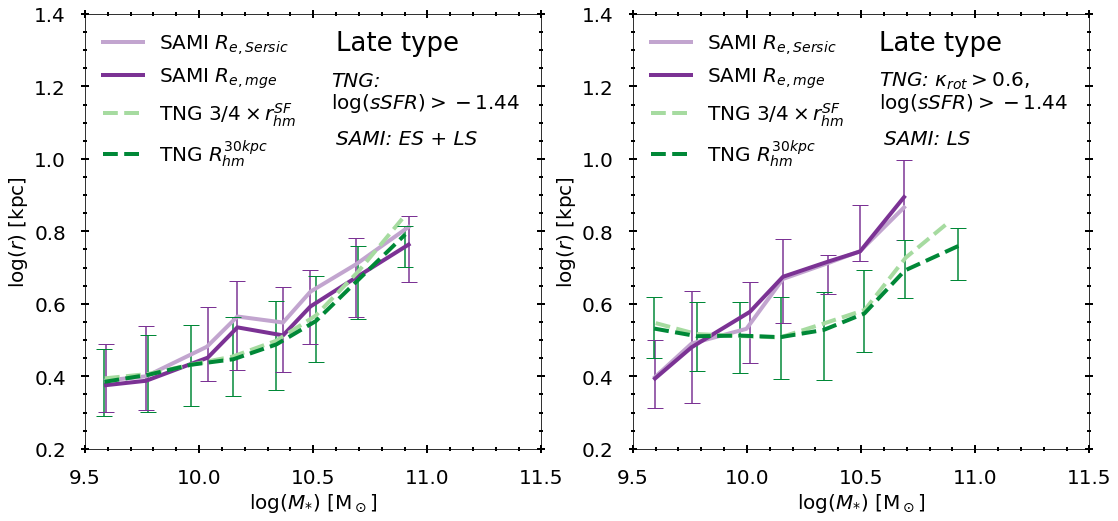

In [53]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8))

#Late type
x_med_s_re_L, y_med_s_re_L, x_err_s_re_L, y_err_s_re_L = il.stats.median_values_df(sami_lates_2_log, "sami", "mstar", "r_e_circ", xmin=9.5, xmax=11, n=9, error_out=True)
x_med_s_rmge_L, y_med_s_rmge_L, x_err_s_rmge_L, y_err_s_rmge_L = il.stats.median_values_df(sami_lates_2_log, "sami", "mstar", "r_mge", xmin=9.5, xmax=11, n=9, error_out=True)

mass_total_L = old_lates_SFR_log["SubhaloMassStellar"].values
mass_30_L = new_lates_SFR_log["SubhaloMassStellar30kpc"].values
r_30_L = new_lates_SFR_log["SubhaloHalfmassRadProj30kpc"].values
r_SF_proj_L = (old_lates_SFR_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values

x_med_30_L, y_med_30_L, x_err_30_L, y_err_30_L = il.stats.median_errors(mass_30_L, r_30_L, 9.5, 11, n=9)
x_med_SF_proj_L, y_med_SF_proj_L, x_err_SF_proj_L, y_err_SF_proj_L = il.stats.median_errors(mass_total_L, r_SF_proj_L, 9.5, 11, n=9)

#plot
#new_lates_log.plot.scatter("SubhaloMassStellar30kpc", "SubhaloHalfmassRadStellar30kpc", ax=axs[1])
axs[0].plot(x_med_s_re_L, y_med_s_re_L, linewidth=4, color="#c2a5cf", label = r"SAMI $R_{e, Sersic}$")
axs[0].errorbar(x_med_s_rmge_L, y_med_s_rmge_L, yerr=y_err_s_rmge_L, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs[0].plot(x_med_s_rmge_L, y_med_s_rmge_L, linewidth=4, color="#7b3294", label = r"SAMI $R_{e, mge}$")
axs[0].plot(x_med_SF_proj_L, y_med_SF_proj_L, "--", linewidth=4, color="#a6dba0", label = r"TNG $3/4 \times r^{SF}_{hm}$")
axs[0].errorbar(x_med_30_L, y_med_30_L, yerr=y_err_30_L, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs[0].plot(x_med_30_L, y_med_30_L, "--", linewidth=4, color="#008837", label = r"TNG $R^{30kpc}_{hm}$")
#Format
il.formatplot.SM_R(axs[0], x0= 9.5, x1= 11.5, y0=0.2, y1=1.4)
axs[0].text(10.6, 1.3, "Late type", fontsize=26)
axs[0].text(10.58, 1.2, r'TNG:', fontsize=20, fontstyle="italic")
axs[0].text(10.58, 1.14, r'$\log(sSFR) > -1.44$', fontsize=20, fontstyle="italic") 
axs[0].text(10.6, 1.04, r'SAMI: ES + LS', fontsize=20, fontstyle="italic") 
#axs[0].text(10.84, 0.96, r'late spirals', fontsize=20, fontstyle="italic") 
#axs[0].text(10.84, 0.96, r'late spirals', fontsize=22) 

#Late type
x_med_s_re_L, y_med_s_re_L, x_err_s_re_L, y_err_s_re_L = il.stats.median_values_df(sami_lates_log, "sami", "mstar", "r_e_circ", xmin=9.5, xmax=11, n=9, error_out=True)
x_med_s_rmge_L, y_med_s_rmge_L, x_err_s_rmge_L, y_err_s_rmge_L = il.stats.median_values_df(sami_lates_log, "sami", "mstar", "r_mge", xmin=9.5, xmax=11, n=9, error_out=True)

mass_total_L = old_lates_log["SubhaloMassStellar"].values
mass_30_L = new_lates_log["SubhaloMassStellar30kpc"].values
r_30_L = new_lates_log["SubhaloHalfmassRadProj30kpc"].values
r_SF_proj_L = (old_lates_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values

x_med_30_L, y_med_30_L, x_err_30_L, y_err_30_L = il.stats.median_errors(mass_30_L, r_30_L, 9.5, 11, n=9)
x_med_SF_proj_L, y_med_SF_proj_L, x_err_SF_proj_L, y_err_SF_proj_L = il.stats.median_errors(mass_total_L, r_SF_proj_L, 9.5, 11, n=9)

#plot
#new_lates_log.plot.scatter("SubhaloMassStellar30kpc", "SubhaloHalfmassRadStellar30kpc", ax=axs[1])
axs[1].plot(x_med_s_re_L, y_med_s_re_L, linewidth=4, color="#c2a5cf", label = r"SAMI $R_{e, Sersic}$")
axs[1].errorbar(x_med_s_rmge_L, y_med_s_rmge_L, yerr=y_err_s_rmge_L, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs[1].plot(x_med_s_rmge_L, y_med_s_rmge_L, linewidth=4, color="#7b3294", label = r"SAMI $R_{e, mge}$")
axs[1].plot(x_med_SF_proj_L, y_med_SF_proj_L, "--", linewidth=4, color="#a6dba0", label = r"TNG $3/4 \times r^{SF}_{hm}$")
axs[1].errorbar(x_med_30_L, y_med_30_L, yerr=y_err_30_L, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs[1].plot(x_med_30_L, y_med_30_L, "--", linewidth=4, color="#008837", label = r"TNG $R^{30kpc}_{hm}$")
#Format
il.formatplot.SM_R(axs[1], x0= 9.5, x1= 11.5, y0=0.2, y1=1.4)
axs[1].text(10.58, 1.3, "Late type", fontsize=26)
axs[1].text(10.58, 1.2, r'TNG: $\kappa_{rot} > 0.6,$ ', fontsize=20, fontstyle="italic")
axs[1].text(10.58, 1.14, r'$\log(sSFR) > -1.44$', fontsize=20, fontstyle="italic") 
axs[1].text(10.6, 1.04, r'SAMI: LS', fontsize=20, fontstyle="italic") 


plt.savefig("../fig/SM_R_lates.png", dpi=300, bbox_inches='tight')


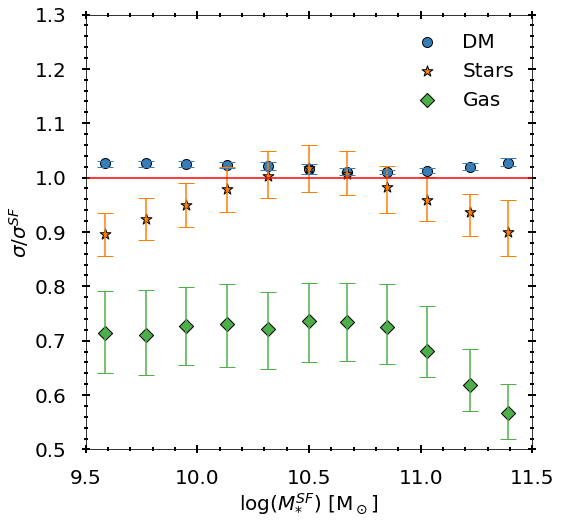

In [16]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
stellar_mass_log = old_log["SubhaloMassStellar"].values
vel_total = old["SubhaloVelDisp"].values
vel_stellar_total = new["SubhaloVelDisp1D_Stellar_Total"].values
vel_gas_total = new["SubhaloVelDisp1D_Gas_Total"].values
vel_dm_total = new["SubhaloVelDisp1D_DM_Total"].values

stellar_mass = new["SubhaloMassStellarTotal"].values
gas_mass = new["SubhaloMassGasTotal"].values
dm_mass = new["SubhaloMassDMTotal"].values
total_mass = stellar_mass + gas_mass + dm_mass
check = (vel_stellar_total*stellar_mass + vel_gas_total*gas_mass + vel_dm_total*dm_mass)/total_mass

frac_stellar = vel_stellar_total/vel_total
frac_gas = vel_gas_total/vel_total
frac_dm = vel_dm_total/vel_total
frac_check = check/vel_total

x_med_stellar, y_med_stellar, x_err_stellar, y_err_stellar = il.stats.median_errors(stellar_mass_log, frac_stellar, 9.5, 11.5)
x_med_gas, y_med_gas, x_err_gas, y_err_gas = il.stats.median_errors(stellar_mass_log, frac_gas, 9.5, 11.5)
x_med_dm, y_med_dm, x_err_dm, y_err_dm = il.stats.median_errors(stellar_mass_log, frac_dm, 9.5, 11.5)
x_med_check, y_med_check, x_err_check, y_err_check = il.stats.median_errors(stellar_mass_log, frac_check, 9.5, 11.5)
#Plot median values

axs.errorbar(x_med_dm, y_med_dm, yerr=y_err_dm, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_dm, y_med_dm, marker='o', s=100, color="#377eb8", edgecolors = "black", label = r"DM")

axs.errorbar(x_med_stellar, y_med_stellar, yerr=y_err_stellar, capsize = 8, color="#ff7f00", marker='^', fmt = 'none')
axs.scatter(x_med_stellar, y_med_stellar, marker='*', s=130, color="#ff7f00", edgecolors = "black", label = r"Stars")

axs.errorbar(x_med_gas, y_med_gas, yerr=y_err_gas, capsize = 8, color="#4daf4a", marker='^', fmt = 'none')
axs.scatter(x_med_gas, y_med_gas, marker='D', s=100, color="#4daf4a", edgecolors = "black", label = r"Gas")

#axs.scatter(x_med_check, y_med_check, marker='D', s=100, color="green", edgecolors = "black", label = r"Check")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.3, x1=11.5)
plt.savefig("../fig/VD_particles.png", dpi=300, bbox_inches='tight')

Text(9.7, 1.2, 'Early type')

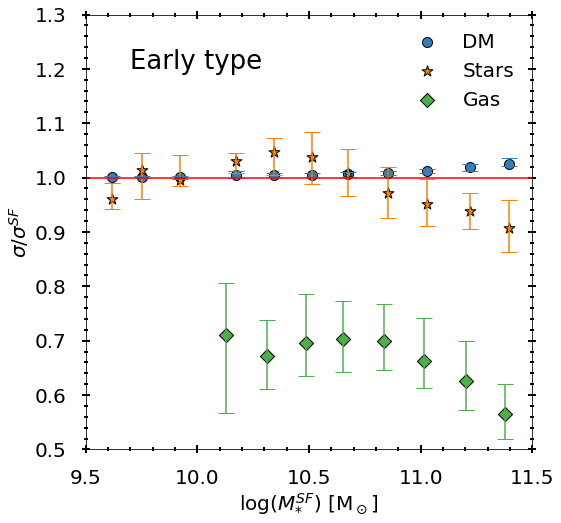

In [17]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
stellar_mass_log = old_earlies_log["SubhaloMassStellar"].values
vel_total = old_earlies["SubhaloVelDisp"].values
vel_stellar_total = new_earlies["SubhaloVelDisp1D_Stellar_Total"].values
vel_gas_total = new_earlies["SubhaloVelDisp1D_Gas_Total"].values
vel_dm_total = new_earlies["SubhaloVelDisp1D_DM_Total"].values

frac_stellar = vel_stellar_total/vel_total
frac_gas = vel_gas_total/vel_total
frac_dm = vel_dm_total/vel_total

x_med_stellar, y_med_stellar, x_err_stellar, y_err_stellar = il.stats.median_errors(stellar_mass_log, frac_stellar, 9.5, 11.5)
x_med_gas, y_med_gas, x_err_gas, y_err_gas = il.stats.median_errors(stellar_mass_log, frac_gas, 10, 11.5, n=9)
x_med_dm, y_med_dm, x_err_dm, y_err_dm = il.stats.median_errors(stellar_mass_log, frac_dm, 9.5, 11.5)
#Plot median values

axs.errorbar(x_med_dm, y_med_dm, yerr=y_err_dm, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_dm, y_med_dm, marker='o', s=100, color="#377eb8", edgecolors = "black", label = r"DM")

axs.errorbar(x_med_stellar, y_med_stellar, yerr=y_err_stellar, capsize = 8, color="#ff7f00", marker='^', fmt = 'none')
axs.scatter(x_med_stellar, y_med_stellar, marker='*', s=130, color="#ff7f00", edgecolors = "black", label = r"Stars")

axs.errorbar(x_med_gas, y_med_gas, yerr=y_err_gas, capsize = 8, color="#4daf4a", marker='^', fmt = 'none')
axs.scatter(x_med_gas, y_med_gas, marker='D', s=100, color="#4daf4a", edgecolors = "black", label = r"Gas")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.3, x1=11.5)
axs.text(9.7, 1.2, "Early type", fontsize=26)

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(9.7, 1.2, 'Late type')

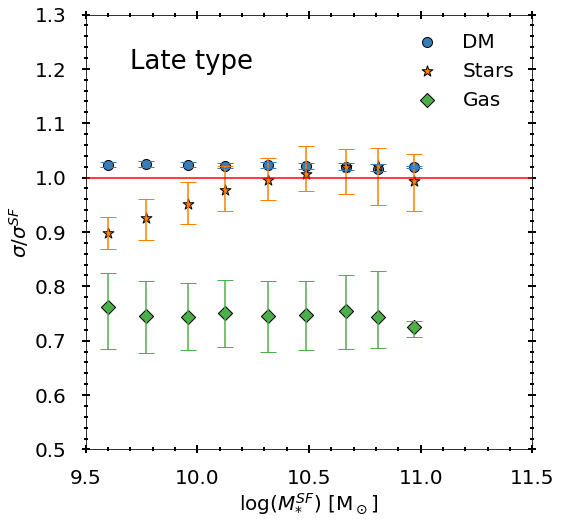

In [18]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
stellar_mass_log = old_lates_log["SubhaloMassStellar"].values
vel_total = old_lates["SubhaloVelDisp"].values
vel_stellar_total = new_lates["SubhaloVelDisp1D_Stellar_Total"].values
vel_gas_total = new_lates["SubhaloVelDisp1D_Gas_Total"].values
vel_dm_total = new_lates["SubhaloVelDisp1D_DM_Total"].values

frac_stellar = vel_stellar_total/vel_total
frac_gas = vel_gas_total/vel_total
frac_dm = vel_dm_total/vel_total

x_med_stellar, y_med_stellar, x_err_stellar, y_err_stellar = il.stats.median_errors(stellar_mass_log, frac_stellar, 9.5, 11.5)
x_med_gas, y_med_gas, x_err_gas, y_err_gas = il.stats.median_errors(stellar_mass_log, frac_gas, 9.5, 11.5)
x_med_dm, y_med_dm, x_err_dm, y_err_dm = il.stats.median_errors(stellar_mass_log, frac_dm, 9.5, 11.5)
#Plot median values

axs.errorbar(x_med_dm, y_med_dm, yerr=y_err_dm, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_dm, y_med_dm, marker='o', s=100, color="#377eb8", edgecolors = "black", label = r"DM")

axs.errorbar(x_med_stellar, y_med_stellar, yerr=y_err_stellar, capsize = 8, color="#ff7f00", marker='^', fmt = 'none')
axs.scatter(x_med_stellar, y_med_stellar, marker='*', s=130, color="#ff7f00", edgecolors = "black", label = r"Stars")

axs.errorbar(x_med_gas, y_med_gas, yerr=y_err_gas, capsize = 8, color="#4daf4a", marker='^', fmt = 'none')
axs.scatter(x_med_gas, y_med_gas, marker='D', s=100, color="#4daf4a", edgecolors = "black", label = r"Gas")


x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.3, x1=11.5)
axs.text(9.7, 1.2, "Late type", fontsize=26)

Text(9.7, 1.2, 'Stars')

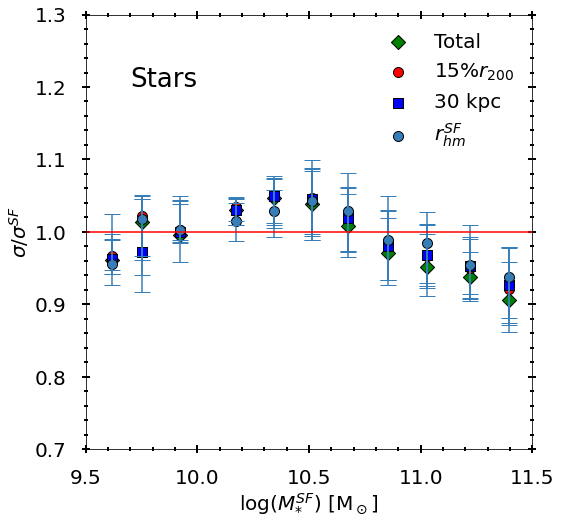

In [19]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
stellar_mass_log = old_earlies_log["SubhaloMassStellar"].values
vel_total = old_earlies["SubhaloVelDisp"].values
vel_stellar_total = new_earlies["SubhaloVelDisp1D_Stellar_Total"].values
vel_stellar_15 = new_earlies["SubhaloVelDisp1D_Stellar_15Rvir"].values
vel_stellar_30 = new_earlies["SubhaloVelDisp1D_Stellar_30kpc"].values
vel_stellar_re_total = new_earlies["SubhaloVelDisp1D_Stellar_Re_Total"].values #missing

frac_total = vel_stellar_total/vel_total
frac_15 = vel_stellar_15/vel_total
frac_30 = vel_stellar_30/vel_total
frac_re_total = vel_stellar_re_total/vel_total

x_med_total, y_med_total, x_err_total, y_err_total = il.stats.median_errors(stellar_mass_log, frac_total, 9.5, 11.5)
x_med_15, y_med_15, x_err_15, y_err_15 = il.stats.median_errors(stellar_mass_log, frac_15, 9.5, 11.5)
x_med_30, y_med_30, x_err_30, y_err_30 = il.stats.median_errors(stellar_mass_log, frac_30, 9.5, 11.5)
x_med_re_total, y_med_re_total, x_err_re_total, y_err_re_total = il.stats.median_errors(stellar_mass_log, frac_re_total, 9.5, 11.5)
#Plot median values

axs.errorbar(x_med_total, y_med_total, yerr=y_err_total, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_total, y_med_total, marker='D', s=100, color="green", edgecolors = "black", label = r"Total")

axs.errorbar(x_med_15, y_med_15, yerr=y_err_15, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_15, y_med_15, marker='o', s=100, color="red", edgecolors = "black", label = r"$15 \% r_{200}$")

axs.errorbar(x_med_30, y_med_30, yerr=y_err_30, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_30, y_med_30, marker='s', s=100, color="blue", edgecolors = "black", label = r"30 kpc")

axs.errorbar(x_med_re_total, y_med_re_total, yerr=y_err_re_total, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_re_total, y_med_re_total, marker='o', s=100, color="#377eb8", edgecolors = "black", label = r'$r_{hm}^{SF}$')

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.7, y1 = 1.3, x1=11.5)
axs.text(9.7, 1.2, "Stars", fontsize=26)

Text(11, 1.2, 'Gas')

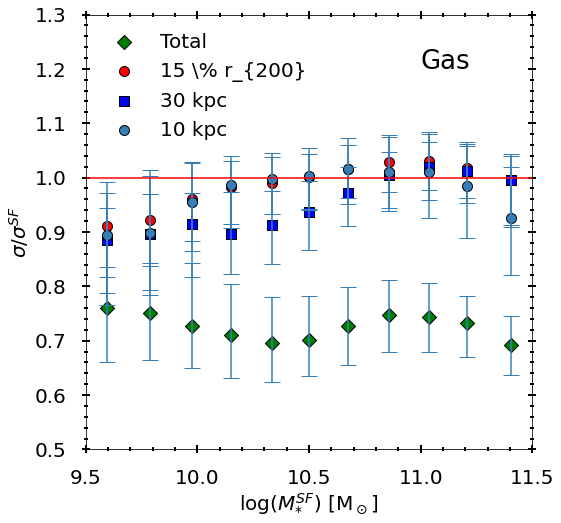

In [20]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
gas_mass_log = old_log["SubhaloMassGas"].values
vel_total = old["SubhaloVelDisp"].values
vel_gas_total = new["SubhaloVelDisp1D_Gas_Total"].values
vel_gas_15 = new["SubhaloVelDisp1D_Gas_15Rvir"].values
vel_gas_30 = new["SubhaloVelDisp1D_Gas_30kpc"].values
vel_gas_10 = new["SubhaloVelDisp1D_Gas_10kpc"].values #missing

frac_total = vel_gas_total/vel_total
frac_15 = vel_gas_15/vel_total
frac_30 = vel_gas_30/vel_total
frac_10 = vel_gas_10/vel_total

x_med_total, y_med_total, x_err_total, y_err_total = il.stats.median_errors(gas_mass_log, frac_total, 9.5, 11.5)
x_med_15, y_med_15, x_err_15, y_err_15 = il.stats.median_errors(gas_mass_log, frac_15, 9.5, 11.5)
x_med_30, y_med_30, x_err_30, y_err_30 = il.stats.median_errors(gas_mass_log, frac_30, 9.5, 11.5)
x_med_10, y_med_10, x_err_10, y_err_10 = il.stats.median_errors(gas_mass_log, frac_10, 9.5, 11.5)
#Plot median values

axs.errorbar(x_med_total, y_med_total, yerr=y_err_total, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_total, y_med_total, marker='D', s=100, color="green", edgecolors = "black", label = r"Total")

axs.errorbar(x_med_15, y_med_15, yerr=y_err_15, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_15, y_med_15, marker='o', s=100, color="red", edgecolors = "black", label = r"15 \% r_{200}")

axs.errorbar(x_med_30, y_med_30, yerr=y_err_30, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_30, y_med_30, marker='s', s=100, color="blue", edgecolors = "black", label = r"30 kpc")

axs.errorbar(x_med_10, y_med_10, yerr=y_err_10, capsize = 8, color="#377eb8", marker='^', fmt = 'none')
axs.scatter(x_med_10, y_med_10, marker='o', s=100, color="#377eb8", edgecolors = "black", label = r"10 kpc")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.3, x1=11.5)
axs.text(11, 1.2, "Gas", fontsize=26)

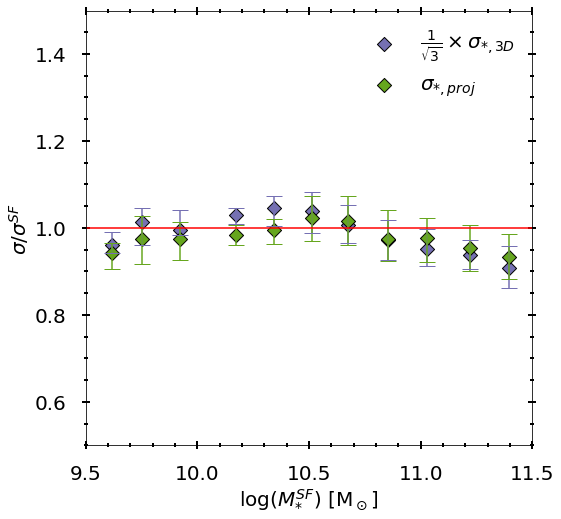

In [21]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points
mass_log = old_earlies_log["SubhaloMassStellar"].values
vel_total = old_earlies["SubhaloVelDisp"].values
vel_stellar = new_earlies["SubhaloVelDisp1D_Stellar_Total"].values
vel_stellar_proj = new_earlies["SubhaloVelDispReProjectedStellarTotal"].values

frac_1 = vel_stellar/vel_total
frac_2 = vel_stellar_proj/vel_total

x_med1, y_med1, x_err1, y_err1 = il.stats.median_errors(mass_log, frac_1, 9.5, 11.5)
x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(mass_log, frac_2, 9.5, 11.5)

#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='D', s=100, color="#7570b3", edgecolors = "black", label = r"$\frac{1}{\sqrt{3}} \times \sigma_{*, 3D}$")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#66a61e", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#66a61e", edgecolors = "black", label = r"$\sigma_{*, proj}$")

x = np.linspace(0, 12, 2)
y = [1]*2
axs.plot(x, y, c="red")

il.formatplot.SM_fVD(ax=axs, y0 = 0.5, y1 = 1.5, x1=11.5)

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


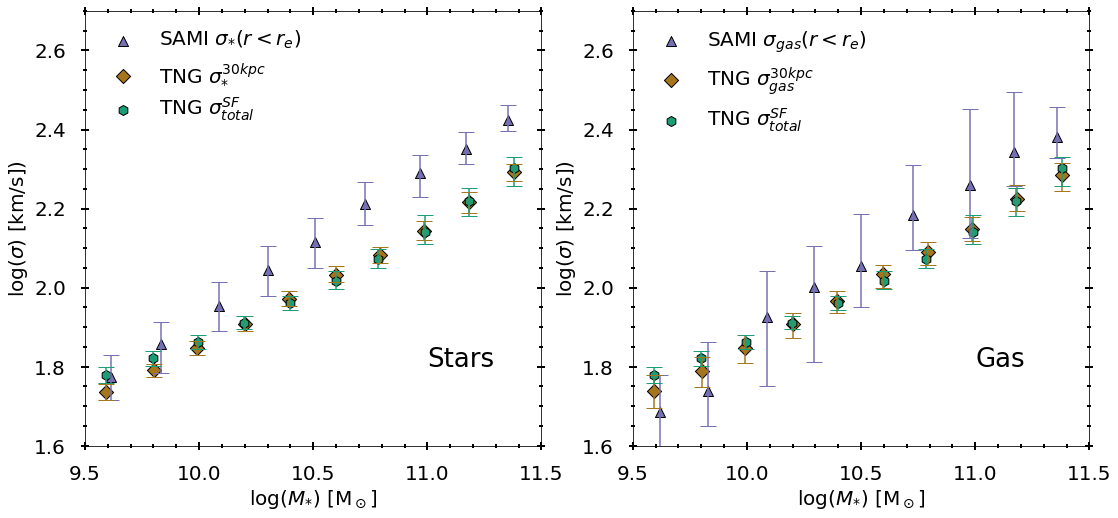

In [22]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8))
#Plot all data points

#Stellar particles
x_med1, y_med1, x_err1, y_err1 = il.stats.median_values_df(sami_log, "sami", "mstar", "sigma_re", xmin=9.5, xmax=12, n=12, error_out=True)

x_vals_2 = new_log["SubhaloMassStellar30kpc"].values
x_vals_3 = old_log["SubhaloMassStellar"].values
new_vals_2 = new_log["SubhaloVelDisp1D_Stellar_30kpc"].values
new_vals_3 = old_log["SubhaloVelDisp"].values

x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_2, new_vals_2, 9.5, 11.5, n=11)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_3, new_vals_3, 9.5, 11.5, n=11)

#sami_earlies_log.plot.scatter(x="mstar", y = "sigma_re",s=20, label="SAMI", alpha=0.5, color="#7570b3", ax = axs)
#Plot median values
axs[0].errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs[0].scatter(x_med1, y_med1, marker='^', s=100, color="#7570b3", edgecolors = "black", label = r"SAMI $\sigma_{*}(r < r_{e})$")

axs[0].errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs[0].scatter(x_med2, y_med2, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"TNG $\sigma_{*}^{30kpc}$")

axs[0].errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#1b9e77", marker='^', fmt = 'none')
axs[0].scatter(x_med3, y_med3, marker='h', s=100, color="#1b9e77", edgecolors = "black", label = r"TNG $\sigma^{SF}_{total}$")
il.formatplot.SM_VD(ax=axs[0], x0 = 9.5, x1=11.5, y0 = 1.6, y1 = 2.7)
axs[0].text(11, 1.8, "Stars", fontsize=26)

#gas
x_med1, y_med1, x_err1, y_err1 = il.stats.median_values_df(sami_log, "sami", "mstar", "vdisp_gas_re", xmin=9.5, xmax=12, n=12, error_out=True)
x_vals_2 = new_log["SubhaloMassStellar30kpc"].values
x_vals_3 = old_log["SubhaloMassStellar"].values
new_vals_2 = new_log["SubhaloVelDisp1D_Gas_30kpc"].values
new_vals_3 = old_log["SubhaloVelDisp"].values

x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_2, new_vals_2, 9.5, 11.5, n=11)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_3, new_vals_3, 9.5, 11.5, n=11)

#sami_earlies_log.plot.scatter(x="mstar", y = "sigma_re",s=20, label="SAMI", alpha=0.5, color="#7570b3", ax = axs)
#Plot median values
axs[1].errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs[1].scatter(x_med1, y_med1, marker='^', s=100, color="#7570b3", edgecolors = "black", label = r"SAMI $\sigma_{gas}(r < r_{e})$")

axs[1].errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs[1].scatter(x_med2, y_med2, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"TNG $\sigma_{gas}^{30kpc}$")

axs[1].errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#1b9e77", marker='^', fmt = 'none')
axs[1].scatter(x_med3, y_med3, marker='h', s=100, color="#1b9e77", edgecolors = "black", label = r"TNG $\sigma^{SF}_{total}$")
il.formatplot.SM_VD(ax=axs[1], x0 = 9.5, x1=11.5, y0 = 1.6, y1 = 2.7)
axs[1].text(11, 1.8, "Gas", fontsize=26)

plt.savefig("../fig/SM_sigma.png", dpi=300, bbox_inches='tight')

slope: [[0.36541989]]
intercept: [-1.70191588]
R^2: 0.9888840828609389
slope: [[0.32848171]]
intercept: [-1.44358309]
R^2: 0.929394145289608


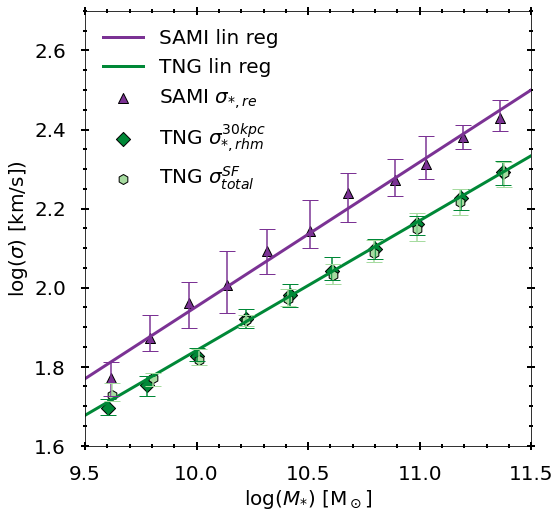

In [55]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points

#Stellar particles
x_med_sami, y_med_sami, x_err_sami, y_err_sami = il.stats.median_values_df(sami_earlies_log, "sami", "mstar", "sigma_re", xmin=9.5, xmax=11.5, n=12, error_out=True)

mass_30 = new_earlies_log["SubhaloMassStellar30kpc"].values
mass_total = old_earlies_log["SubhaloMassStellar"].values
vel_30 = new_earlies_log["SubhaloVelDispReProjectedStellar30kpc"].values
#vel_30 = new_earlies_log["SubhaloVelDisp1D_Stellar_30kpc"].values
vel_total = old_earlies_log["SubhaloVelDisp"].values

x_med_30, y_med_30, x_err_30, y_err_30 = il.stats.median_errors(mass_30, vel_30, 9.5, 11.5, n=11)
x_med_total, y_med_total, x_err_total, y_err_total = il.stats.median_errors(mass_total, vel_total, 9.5, 11.5, n=11)

#Linear regression
regX_S1, regY_S1 = il.stats.lin_reg(x_med_sami, y_med_sami, xmin=9.5, xmax=12)
axs.plot(regX_S1, regY_S1, linewidth = 3, label ="SAMI lin reg", color="#7b3294")

regX_TNG1, regY_TNG1 = il.stats.lin_reg(mass_30, vel_30, xmin=9.5, xmax=12)
axs.plot(regX_TNG1, regY_TNG1, linewidth = 3, label ="TNG lin reg", color="#008837")

#Plot median values
axs.errorbar(x_med_sami, y_med_sami, yerr=y_err_sami, capsize = 8, color="#7b3294", marker='^', fmt = 'none')
axs.scatter(x_med_sami, y_med_sami, marker='^', s=100, color="#7b3294", edgecolors = "black", label = r"SAMI $\sigma_{*, re}$")

axs.errorbar(x_med_30, y_med_30, yerr=y_err_30, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs.scatter(x_med_30, y_med_30, marker='D', s=100, color="#008837", edgecolors = "black", label = r"TNG $\sigma_{*, rhm}^{30kpc}$")

axs.errorbar(x_med_total, y_med_total, yerr=y_err_total, capsize = 8, color="#a6dba0", marker='^', fmt = 'none')
axs.scatter(x_med_total, y_med_total, marker='h', s=100, color="#a6dba0", edgecolors = "black", label = r"TNG $\sigma^{SF}_{total}$")
il.formatplot.SM_VD(ax=axs, x0 = 9.5, x1=11.5, y0 = 1.6, y1 = 2.7)

plt.savefig("../fig/FJ.png", dpi=300, bbox_inches='tight')

C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\auror\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


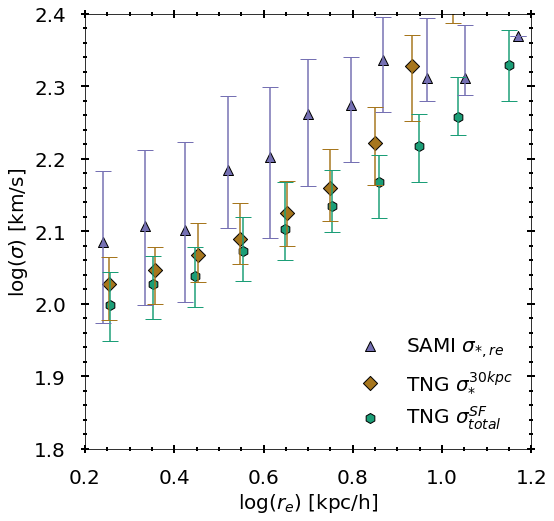

In [24]:
#Draw figure
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
#Plot all data points

#Stellar particles
x_med1, y_med1, x_err1, y_err1 = il.stats.median_values_df(sami_earlies_log, "sami", "r_e_circ", "sigma_re", xmin=0.2, xmax=1.2, n=12, error_out=True)

x_vals_2 = new_earlies_log["SubhaloHalfmassRadProj30kpc"].values
x_vals_3 = (old_earlies_log["SubhaloHalfmassRadStellar"] + np.log10(3/4)).values
new_vals_2 = new_earlies_log["SubhaloVelDisp1D_Stellar_30kpc"].values
new_vals_3 = old_earlies_log["SubhaloVelDisp"].values

x_med2, y_med2, x_err2, y_err2 = il.stats.median_errors(x_vals_2, new_vals_2, 0.2, 1.2, n=11)
x_med3, y_med3, x_err3, y_err3 = il.stats.median_errors(x_vals_3, new_vals_3, 0.2, 1.2, n=11)

#sami_earlies_log.plot.scatter(x="mstar", y = "sigma_re",s=20, label="SAMI", alpha=0.5, color="#7570b3", ax = axs)
#Plot median values
axs.errorbar(x_med1, y_med1, yerr=y_err1, capsize = 8, color="#7570b3", marker='^', fmt = 'none')
axs.scatter(x_med1, y_med1, marker='^', s=100, color="#7570b3", edgecolors = "black", label = r"SAMI $\sigma_{*, re}$")

axs.errorbar(x_med2, y_med2, yerr=y_err2, capsize = 8, color="#a6761d", marker='^', fmt = 'none')
axs.scatter(x_med2, y_med2, marker='D', s=100, color="#a6761d", edgecolors = "black", label = r"TNG $\sigma_{*}^{30kpc}$")

axs.errorbar(x_med3, y_med3, yerr=y_err3, capsize = 8, color="#1b9e77", marker='^', fmt = 'none')
axs.scatter(x_med3, y_med3, marker='h', s=100, color="#1b9e77", edgecolors = "black", label = r"TNG $\sigma^{SF}_{total}$")
il.formatplot.R_VD(ax=axs, x0=0.2, x1=1.2, y0=1.8, y1=2.4)

plt.savefig("../fig/R_VD.png", dpi=300, bbox_inches='tight')

slope: [[0.31]]
intercept: [-0.93859837]
R^2: 1.0
slope: [[0.24985148]]
intercept: [-0.348893]
R^2: 0.9986392266516934
slope: [[0.23982787]]
intercept: [-0.24264073]
R^2: 0.9974260646713518


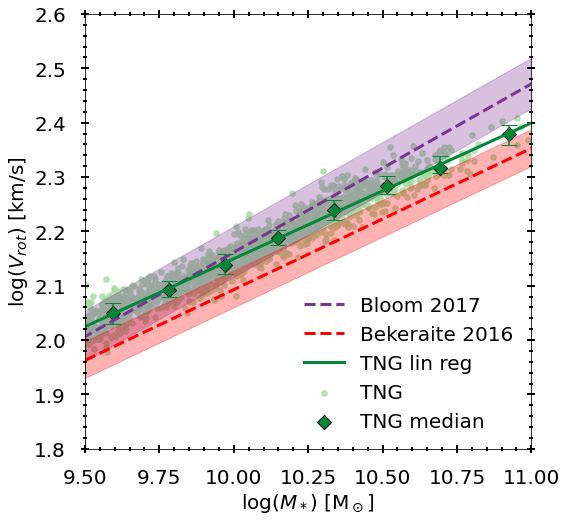

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))

mass_30 = new_lates_log["SubhaloMassStellar30kpc"].values
mass_total = old_lates_log["SubhaloMassStellar"].values
v_Re22_30 = new_lates_log["SubhaloRotVelRe2230kpc"].values
v_max = old_lates_log["SubhaloVmax"].values

#TNG
#Calculate median values + percentiles
x_med_30, y_med_30, x_err_30, y_err_30 = il.stats.median_errors(mass_30 , v_Re22_30, 9.5, 11, n=9)
x_med_max, y_med_max, x_err_max, y_err_max = il.stats.median_errors(mass_total , v_max, 9.5, 11, n=9)
#x_med_sami, y_med_sami, x_err_sami, y_err_sami = il.stats.median_values_df(sami_lates_log, "sami", "mstar", "V_rot", xmin=10.2, xmax=11, n=7, error_out=True)
new_lates_log.plot.scatter(x="SubhaloMassStellar30kpc", y="SubhaloRotVelRe2230kpc", s=30, label = r"TNG", alpha=0.8, color="#a6dba0", ax = axs)

#Bloom 2018
B2018x, B2018y = power_law_log(C=-0.93, a=0.31, xmin = 9, xmax = 11.5)
B2018x = B2018x + np.log10(h_sami**2/h_tng**2) #converting to same cosmology
reg1, reg2 = il.stats.lin_reg(B2018x, B2018y, xmin=9.5, xmax=(11.5))

axs.plot(B2018x, B2018y, '--', linewidth = 3, label = r"Bloom 2017", c= "#7b3294")
axs.fill_betweenx(B2018y, B2018x -0.15, B2018x +0.15, alpha=0.3, color="#7b3294")

#CANDLES
Cx, Cy = power_law_log(C=-0.5, a=0.26, xmin = 9, xmax = 11.5)
Cx = Cx + np.log10(h_sami**2/h_tng**2) #converting to same cosmology

axs.plot(Cx, Cy, '--', linewidth = 3, label = r"Bekeraite 2016", c= "red")
axs.fill_betweenx(Cy, Cx -0.13, Cx +0.13, alpha=0.3, color="red")

#Linear regression
regX_TNG1, regY_TNG1 = il.stats.lin_reg(x_med_30, y_med_30, xmin=9.5, xmax=(11))
regX_TNG2, regY_TNG2 = il.stats.lin_reg(x_med_max, y_med_max, xmin=9.5, xmax=(11.5))
axs.plot(regX_TNG1, regY_TNG1, linewidth = 3, label ="TNG lin reg", color="#008837")
#axs.plot(regX_TNG2, regY_TNG2, linewidth = 3, label ="SF lin reg", color="orange")

#Plot median values
axs.errorbar(x_med_30, y_med_30, yerr=y_err_30, capsize = 8, color="#008837", marker='^', fmt = 'none')
axs.scatter(x_med_30, y_med_30, marker='D', s=100, color="#008837", edgecolors = "black", label = r"TNG median")


il.formatplot.SM_Vmax(ax=axs, x0=9.5, x1=11.0, y0=1.8, y1=2.6)
plt.savefig("../fig/TFR.png", dpi=300, bbox_inches='tight')

No handles with labels found to put in legend.


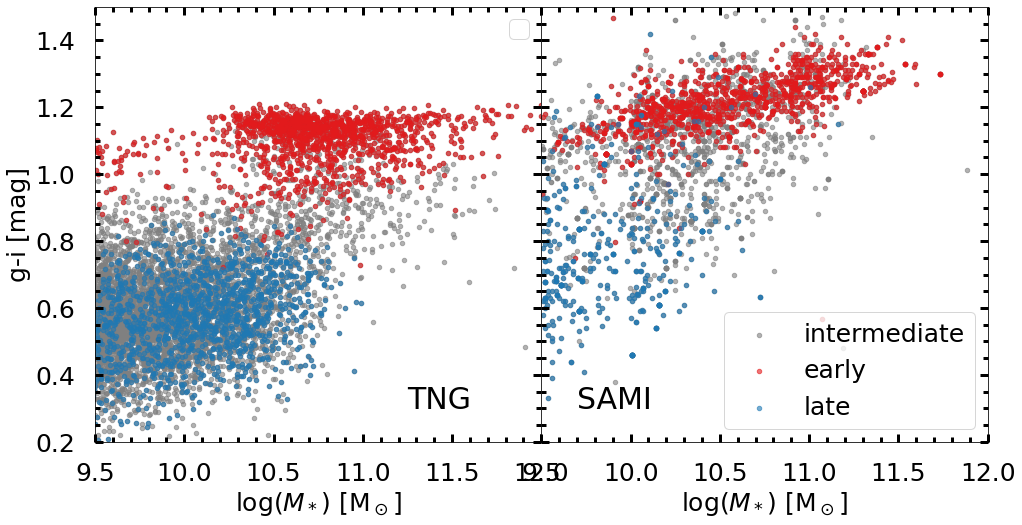

In [26]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(16,8), sharey=True, sharex=True, squeeze=True)
#plot
new_earlies["SubhaloColor_g-iTotal"] = old_earlies["SubhaloColor_g-i"]
new_lates["SubhaloColor_g-iTotal"] = old_lates["SubhaloColor_g-i"]
new_log.plot.scatter(x="SubhaloMassStellar30kpc", y="SubhaloColor_g-i30kpc", color='grey', s=20, alpha=0.6, ax=axs[0])
new_earlies_log.plot.scatter(x="SubhaloMassStellar30kpc", y="SubhaloColor_g-i30kpc", color='#e31a1c', s=20, alpha=0.6, ax=axs[0])
new_lates_log.plot.scatter(x="SubhaloMassStellar30kpc", y="SubhaloColor_g-i30kpc", color='#1f78b4', s=20, alpha=0.6, ax=axs[0])
axs[0].text(11.25, 0.3, "TNG", fontsize=30)
il.formatplot.C_SM(color="g-i", ax=axs[0], y0=0.2, y1=1.5, x0=9.5)

sami.plot.scatter(x="mstar_log", y="g_i", color='grey', s=20, alpha=0.6, ax=axs[1], label ="intermediate")
sami_earlies.plot.scatter(x="mstar_log", y="g_i", color='#e31a1c', s=20, alpha=0.6, ax=axs[1], label ="early")
sami_lates.plot.scatter(x="mstar_log", y="g_i", color='#1f78b4', s=20, alpha=0.6, ax=axs[1], label ="late")
axs[1].text(9.7, 0.3, "SAMI", fontsize=30)
il.formatplot.C_SM(color="g-i", ax=axs[1], y0=0.2, y1=1.5, x0=9.5)

fig.subplots_adjust(hspace=1, wspace=0)
plt.savefig("../fig/CB.png", dpi=300, bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


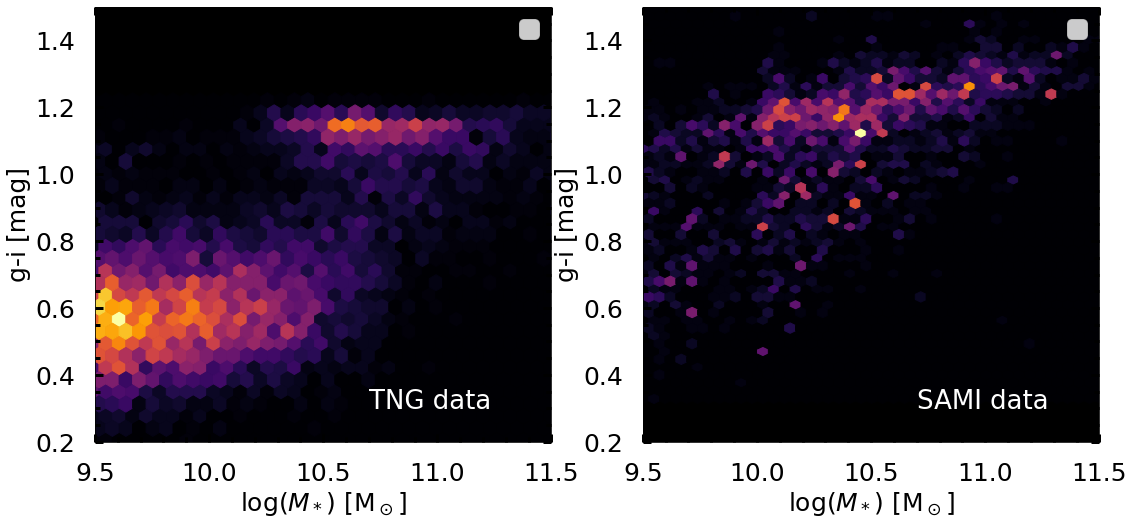

In [27]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(18,8))
#plot
#new_log.plot.scatter(x="SubhaloMassStellar30kpc", y="SubhaloColor_g-i30kpc", color='green', s=20, alpha=0.6, ax=axs[0], label ="TNG")
new_log.plot.hexbin(x="SubhaloMassStellar30kpc", y="SubhaloColor_g-i30kpc", gridsize=[100,15], ax=axs[0], label ="TNG", colormap="inferno", colorbar=False)
#sami.plot.scatter(x="mstar_log", y="g_i", color='purple', s=20, alpha=0.6, ax=axs[1], label ="SAMI")
sami.plot.hexbin(x="mstar_log", y="g_i", gridsize=[50,35], ax=axs[1], label ="SAMI", colormap="inferno", colorbar=False)
il.formatplot.C_SM(color="g-i", ax=axs[0], y0=0.2, y1=1.5, x0=9.5, x1=11.5)
axs[0].set_facecolor("black")
axs[0].text(10.7, 0.3, "TNG data", color="white", fontsize=26)
il.formatplot.C_SM(color="g-i", ax=axs[1], y0=0.2, y1=1.5, x0=9.5, x1=11.5)
axs[1].set_facecolor("black")
axs[1].text(10.7, 0.3, "SAMI data", color="white", fontsize=26)
#fig.subplots_adjust(hspace=1, wspace=0)
plt.savefig("../fig/CB_density.png", dpi=300, bbox_inches='tight')

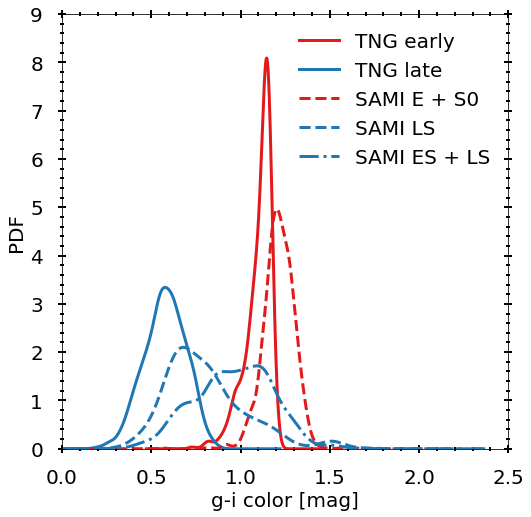

In [42]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
ser1, ser2 = new_earlies["SubhaloColor_g-i30kpc"], new_lates["SubhaloColor_g-i30kpc"]
ser3, ser4 = sami_earlies["g_i"], sami_lates["g_i"]
ser5 = sami_lates_2["g_i"]
ser1.plot.kde(ax=ax, color = '#e31a1c', linewidth=3, label="TNG early")
ser2.plot.kde(ax=ax, color = '#1f78b4', linewidth=3, label="TNG late")
ser3.plot.kde(ax=ax, label="SAMI E + S0", color = '#e31a1c', linewidth=3, linestyle="--")
ser4.plot.kde(ax=ax, label="SAMI LS", color = '#1f78b4', linewidth=3, linestyle="--")
ser5.plot.kde(ax=ax, label="SAMI ES + LS", color = '#1f78b4', linewidth=3, linestyle="-.")
il.formatplot.PDF_C('g-i', ax, legend_on=True, x0=0.0, x1=2.5, y1=9)
plt.savefig("../fig/CB_PDF.png", dpi=300, bbox_inches='tight')


In [29]:
rad = old.copy()
rad.sort_values(by="SubhaloMassStellar", ascending=False, inplace=True)
#print(rad["SubhaloHalfmassRadStellar"][0:30])
part = list(rad["SubhaloLenType"].values)
print(part[-6][4])

3058
